In [1]:
!pip install evaluate
!pip install --upgrade transformers
import pandas as pd
import numpy as np
import evaluate
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# --- 1. Carga e Limpeza dos Dados Reais (Kaggle) ---

print("Carregando dataset B2W...")
# Certifique-se de que o arquivo 'B2W-Reviews01.csv' está na mesma pasta
try:
    # O dataset B2W usa ';' como separador, diferente do padrão ','
    # CORREÇÃO: Pelo erro, o separador parece ser na verdade a vírgula ','
    df = pd.read_csv('B2W-Reviews01.csv', sep=',', on_bad_lines='skip', low_memory=False)
except FileNotFoundError:
    print("ERRO: Arquivo 'B2W-Reviews01.csv' não encontrado.")
    print("Por favor, baixe o dataset do Kaggle e faça o upload.")
    # Para o código não quebrar se você rodar sem o arquivo, vou criar um dummy só para demonstração:
    df = pd.DataFrame({'review_text': ['Teste'], 'overall_rating': [5]})

# --- Diagnóstico: Verificar colunas lidas ---
print(f"Colunas lidas: {df.columns.tolist()}")

# Filtrar apenas as colunas que importam
df = df[['review_text', 'overall_rating']]

# Limpeza Crítica: Remover linhas onde o texto é nulo/vazio
print(f"Tamanho original: {len(df)}")
df = df.dropna(subset=['review_text'])
df['review_text'] = df['review_text'].astype(str) # Garante que tudo é string
print(f"Tamanho após limpeza de nulos: {len(df)}")

Carregando dataset B2W...
Colunas lidas: ['submission_date', 'reviewer_id', 'product_id', 'product_name', 'product_brand', 'site_category_lv1', 'site_category_lv2', 'review_title', 'overall_rating', 'recommend_to_a_friend', 'review_text', 'reviewer_birth_year', 'reviewer_gender', 'reviewer_state']
Tamanho original: 132373
Tamanho após limpeza de nulos: 129098


##
2

In [2]:
# --- 2. Lógica de Negócio: Transformar Estrelas em Sentimento ---

def converter_nota_para_sentimento(nota):
    if nota <= 2:
        return 0 # Negativo
    elif nota == 3:
        return 1 # Neutro
    else:
        return 2 # Positivo
# Aplica a função
df['labels'] = df['overall_rating'].apply(converter_nota_para_sentimento)

# OTIMIZAÇÃO: Balanceamento e Amostragem
# Datasets reais costumam ter muito mais avaliações positivas.
# Para treinar rápido e validar o conceito, vamos pegar uma amostra balanceada (ex: 1500 de cada).
# Isso evita que o modelo vicie em dizer que "tudo é positivo".

df_neg = df[df['labels'] == 0].sample(n=1500, random_state=42)
df_neu = df[df['labels'] == 1].sample(n=1500, random_state=42)
df_pos = df[df['labels'] == 2].sample(n=1500, random_state=42)

df_balanced = pd.concat([df_neg, df_neu, df_pos])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True) # Embaralhar

print(f"Dataset final balanceado: {len(df_balanced)} exemplos.")

Dataset final balanceado: 4500 exemplos.


##3


In [3]:
# --- 3. Preparação para o Hugging Face ---
# Mapeamento para referência futura
id2label = {0: "Negativo", 1: "Neutro", 2: "Positivo"}
label2id = {"Negativo": 0, "Neutro": 1, "Positivo": 2}
# Divisão Treino/Teste
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

# Converter para formato Dataset do HF
dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

# Tokenização (Igual ao exemplo anterior, mas agora com dados reais)
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # Truncation é vital aqui pois algumas reviews podem ser textões enormes
    return tokenizer(examples['review_text'], padding="max_length", truncation=True, max_length=128)

tokenized_train = dataset_train.map(tokenize_function, batched=True)
tokenized_test = dataset_test.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

##4


In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Argumentos otimizados para um "Fine-Tuning" rápido e eficiente
training_args = TrainingArguments(
    output_dir="b2w_bert_finetuned",
    eval_strategy="epoch", # Alterado de evaluation_strategy para eval_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, # Aumentei um pouco pois diminuimos o max_length para 128
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none" # Desabilita logs externos (wandb) para manter simples
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- 5. Execução ---
print("Iniciando treinamento com dados reais do B2W...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2716107733.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando treinamento com dados reais do B2W...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.602709,0.740000
2,No log,0.606690,0.753333
3,0.573900,0.634016,0.768889


TrainOutput(global_step=675, training_loss=0.52132080078125, metrics={'train_runtime': 295.0515, 'train_samples_per_second': 36.604, 'train_steps_per_second': 2.288, 'total_flos': 710406227865600.0, 'train_loss': 0.52132080078125, 'epoch': 3.0})

##5.


Acurácia no conjunto de teste: 0.7688888888888888
Modelo salvo com sucesso. Pronto para o Projeto 2!
Calculando previsões no conjunto de teste...

--- Relatório de Classificação Detalhado ---
              precision    recall  f1-score   support

    Negativo       0.87      0.83      0.85       323
      Neutro       0.63      0.66      0.64       275
    Positivo       0.81      0.81      0.81       302

    accuracy                           0.77       900
   macro avg       0.77      0.76      0.76       900
weighted avg       0.77      0.77      0.77       900

Gerando Matriz de Confusão...


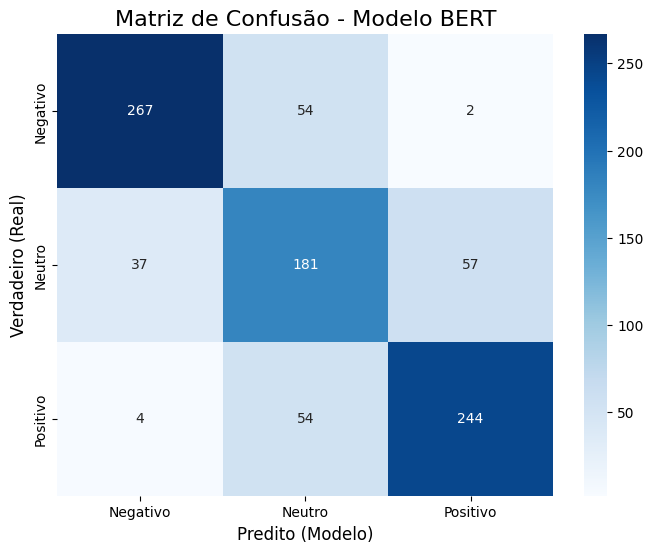

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline
import seaborn as sns
# Avaliação final
metrics = trainer.evaluate()
print("\nAcurácia no conjunto de teste:", metrics['eval_accuracy'])

# Salvar o modelo final
trainer.save_model("./modelo_b2w_sentimento")
print("Modelo salvo com sucesso. Pronto para o Projeto 2!")

# --- 1. Obter Previsões e Rótulos Verdadeiros ---

# O trainer.predict() nos dá as previsões (logits) e os rótulos verdadeiros
print("Calculando previsões no conjunto de teste...")
predictions_output = trainer.predict(tokenized_test)

# predictions_output.predictions são os logits (valores brutos de saída)
# Usamos np.argmax para encontrar o índice da classe com maior probabilidade
y_pred = np.argmax(predictions_output.predictions, axis=1)

# predictions_output.label_ids são os rótulos verdadeiros
y_true = predictions_output.label_ids

# Nossos rótulos (importante manter a ordem: 0, 1, 2)
class_labels = ["Negativo", "Neutro", "Positivo"]

# --- 2. Relatório de Classificação (Precision, Recall, F1) ---

print("\n--- Relatório de Classificação Detalhado ---")
# Isso é mais poderoso que apenas sensibilidade/especificidade para 3 classes
# "Recall" é o mesmo que "Sensibilidade"
print(classification_report(y_true, y_pred, target_names=class_labels))

# --- 3. Plotar a Matriz de Confusão ---

print("Gerando Matriz de Confusão...")
cm = confusion_matrix(y_true, y_pred)

# O código que você forneceu, adaptado para nossos rótulos
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,     # Escreve os números dentro das células
            fmt='d',        # Formato dos números (inteiro)
            cmap='Blues',   # Esquema de cores
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title('Matriz de Confusão - Modelo BERT', fontsize=16)
plt.ylabel('Verdadeiro (Real)', fontsize=12)
plt.xlabel('Predito (Modelo)', fontsize=12)
plt.show()

In [24]:
from transformers import pipeline
import pandas as pd
import os

# Excluir explicitamente a variável de ambiente HF_TOKEN para evitar problemas de autenticação
os.environ.pop('HF_TOKEN', None)

# 1. Carregar o pipeline de NER pré-treinado para português
# O 'aggregation_strategy="simple"' agrupa sub-palavras
# Ex: "Ama" e "##zon" se tornam "Amazon" com a tag ORG
print("Carregando modelo NER (pode levar um momento)...")
# Usando um modelo NER multilíngue genérico que costuma funcionar sem token
nlp_ner = pipeline("ner",
                   model="Davlan/bert-base-multilingual-cased-ner-hrl",
                   aggregation_strategy="simple",
                   token=None) # Garantir que nenhum token seja usado

print("Modelo carregado.")

# 2. Vamos usar alguns dos seus exemplos e adicionar um com marcas
textos_para_teste = [
    "Excelente produto, recomendo. A entrega da Magalu foi rápida.",
    "Nao recebi o produto, quero meu dinheiro de volta. Falei com o atendente João.",
    "não consigo encontrar maquiagem na black friday que meu bolso consegue pagar... triste & sem dinheiro",
    "Man tô na mesma situação tô com 100 reais na carteira da psn já a 2 semanas esperando a Black Friday pra comprar o days gone",
    "Comprei um iPhone 12 na loja da Vivo em São Paulo e estou adorando."
]

print("\n--- Iniciando Extração de Entidades ---")

# 3. Processar cada texto e exibir os resultados
for i, texto in enumerate(textos_para_teste):
    print(f"\n[ Texto {i+1} ]: \"{texto}\"")

    # Executa o pipeline
    entities = nlp_ner(texto)

    if not entities:
        print(" -> Nenhuma entidade reconhecida.")
    else:
        # Imprime as entidades encontradas
        print(" -> Entidades encontradas:")
        for ent in entities:
            print(f"    - Entidade: '{ent['word']}'")
            print(f"      Tipo: {ent['entity_group']}") # entity_group é o nome da label (ex: ORG, PER)
            print(f"      Confiança: {ent['score']:.2%}")

Carregando modelo NER (pode levar um momento)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Modelo carregado.

--- Iniciando Extração de Entidades ---

[ Texto 1 ]: "Excelente produto, recomendo. A entrega da Magalu foi rápida."
 -> Nenhuma entidade reconhecida.

[ Texto 2 ]: "Nao recebi o produto, quero meu dinheiro de volta. Falei com o atendente João."
 -> Entidades encontradas:
    - Entidade: 'João'
      Tipo: PER
      Confiança: 99.91%

[ Texto 3 ]: "não consigo encontrar maquiagem na black friday que meu bolso consegue pagar... triste & sem dinheiro"
 -> Nenhuma entidade reconhecida.

[ Texto 4 ]: "Man tô na mesma situação tô com 100 reais na carteira da psn já a 2 semanas esperando a Black Friday pra comprar o days gone"
 -> Nenhuma entidade reconhecida.

[ Texto 5 ]: "Comprei um iPhone 12 na loja da Vivo em São Paulo e estou adorando."
 -> Entidades encontradas:
    - Entidade: 'Vivo'
      Tipo: ORG
      Confiança: 95.61%
    - Entidade: 'São Paulo'
      Tipo: LOC
      Confiança: 99.93%
